# Intepretable Machine Learning: PD9

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Wczytywanie i transformacja danych, uczenie modeli

In [2]:
X = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.data', sep=' ', header=None)
y = pd.read_csv('https://raw.githubusercontent.com/vlosing/driftDatasets/master/artificial/hyperplane/rotatingHyperplane.labels', header=None)

In [3]:
X.shape

(200000, 10)

In [4]:
X_1 = X.head(20000)
y_1 = y.head(20000).values.reshape(-1)
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.25)


X_10 = X.tail(20000)
y_10 = y.tail(20000).values.reshape(-1)
X_10_train, X_10_test, y_10_train, y_10_test = train_test_split(X_10, y_10, test_size = 0.25)

In [5]:
logreg1 = LogisticRegression()
_ = logreg1.fit(X_1_train, y_1_train)
logreg10 = LogisticRegression()
_ = logreg10.fit(X_10_train, y_10_train)

C:\Users\Koscial\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Koscial\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Variable drift

In [6]:
def variable_drift(old, new, no_bins = 50, subplot=None):
    concat = pd.concat([old, new])
    bins = concat.quantile(np.linspace(0, 1, no_bins + 1))
    
    # Subplotting
    if subplot:
        plt.subplot(*subplot)
    
    # Creating histograms
    old_hist = plt.hist(old, bins=bins, density=True, alpha=0.5, label="Old")
    new_hist = plt.hist(new, bins=bins, density=True, alpha=0.5, label="New")
    
    plt.legend(loc='lower left')
    
    #Computing overlap
    intersect = np.minimum(old_hist[0], new_hist[0]) @ np.diff(bins)
    plt.text(x=0, y=0.25, s='The overlap is {:.4f}'.format(intersect))
    if not subplot:
        plt.show()

Według repozytorium, z którego pochodzą dane oraz cytowanego tam artykułu, w tym zbiorze wygenerowano zmienne objaśniające zgodnie z rozkładem jednostajnym na 10-wymiarowej kostce. Zmienna celu była określana przez obracającą się hiperpłaszczyznę. Z tego powodu wydaje mi się, że _nie powinniśmy_ obserwować żadnego istotnego dryfu w przypadku predyktorów - z założenia nie się zmieniają, a sposób wyznaczania zmiennej objaśnianej. Jest to zgodne z poniższymi wykresami.

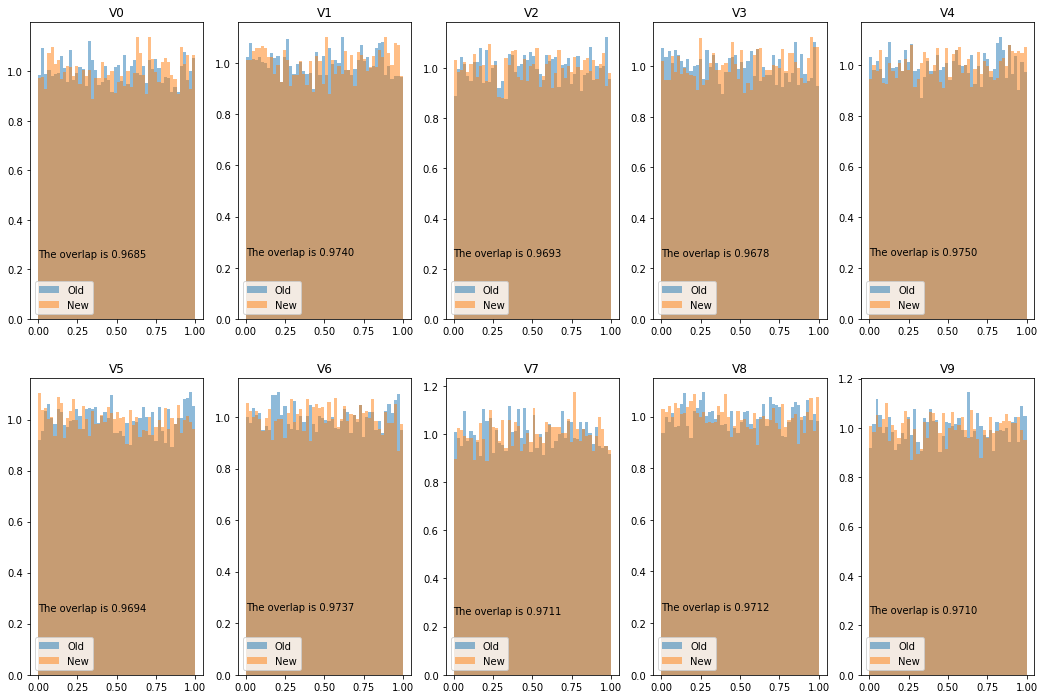

In [7]:
plt.figure(figsize=(18,12))
for i in range(10):
    variable_drift(X_1.loc[:,i], X_10.loc[:,i], subplot=(2, 5, i+1))
    plt.title('V{}'.format(str(i)))
plt.show(block=True)

## Residuals drift

Inaczej ma się sytuacja w przypadku reszt z modelu. Najpierw losowo podzieliłem zbiór `X_1` na treningowy i testowy, na pierwszym nauczyłem regresję logistyczną, a drugi posłużył do stworzenia niebieskiego histogramu poniżej. Następnie przy użyciu tego samego modelu dokonałem predykcji na zbiorze `X_10`, reszty utworzyły pomarańczowy histogram, o zauważalnie grubszych ogonach. Jest to sensowna obserwacja - w przypadku `X_10` hiperpłaszczyzna decyzyjna zdążyła się obrócić, o czym model "nie wie", więc spodziewamy się pogorszenia jakości predykcji.

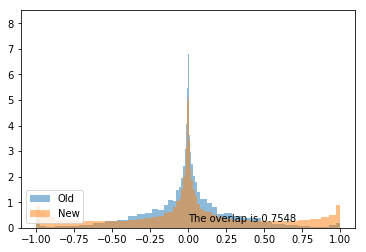

In [8]:
variable_drift(pd.Series(y_1_test - logreg1.predict_proba(X_1_test)[:, 1]), 
               pd.Series(y_10 - logreg1.predict_proba(X_10)[:, 1]))

## Zmiana w odpowiedzi modelu

In [9]:
def pdps_diff(model1, model2, X1, X2, no_points, ylim=None, subplot=None):
    assert np.alltrue(X1.columns == X2.columns)
    half_len = (len(X1.columns) + 1) // 2
    fig, ax_tuple = plt.subplots(2, half_len, sharey=True, figsize=(18,12))
    for idx, var in enumerate(X1.columns):
        df1 = pd.concat([X1] * no_points)
        df2 = pd.concat([X2] * no_points)
        df1[var] = np.repeat(np.linspace(X1[var].min(), X1[var].max(), no_points), X1.shape[0])
        df2[var] = np.repeat(np.linspace(X2[var].min(), X2[var].max(), no_points), X2.shape[0])
        df1['preds'] = model1.predict_proba(df1)[:,1]
        df2['preds'] = model2.predict_proba(df2)[:,1]
        df1 = df1.groupby(var).agg({'preds':'mean'}).reset_index()
        df2 = df2.groupby(var).agg({'preds':'mean'}).reset_index()
        curr_ax = ax_tuple[idx // half_len, idx % half_len]
        curr_ax.plot(df1[var], df1['preds'], label='Old')
        curr_ax.plot(df2[var], df2['preds'], color='black', label='New')
        curr_ax.fill_between(df1[var], df1['preds'], df2['preds'], 
                             where=df2['preds'] >= df1['preds'], facecolor='green', 
                             alpha=0.3, interpolate=True)
        curr_ax.fill_between(df1[var], df1['preds'], df2['preds'], 
                             where=df2['preds'] < df1['preds'], facecolor='red', 
                             alpha=0.3, interpolate=True)
        area = (df1['preds'] - df2['preds']).abs().iloc[1:] @ np.diff(df1[var])
        curr_ax.text(x=0, y=0.1, s='Pole miedzy krzywymi: {:.4f}'.format(area))
        curr_ax.set_title('Variable {}'.format(str(var + 1)))
        curr_ax.legend()

Dla każdej z regresji logistycznych tworzę profile PDP na odpowiednich zbiorach testowych oraz liczę pole pomiędzy wykresami. Całkowanie odbywa się jako sumowanie pól małych prostokątów, ale przy sporej liczbie punktów błąd będzie mały.

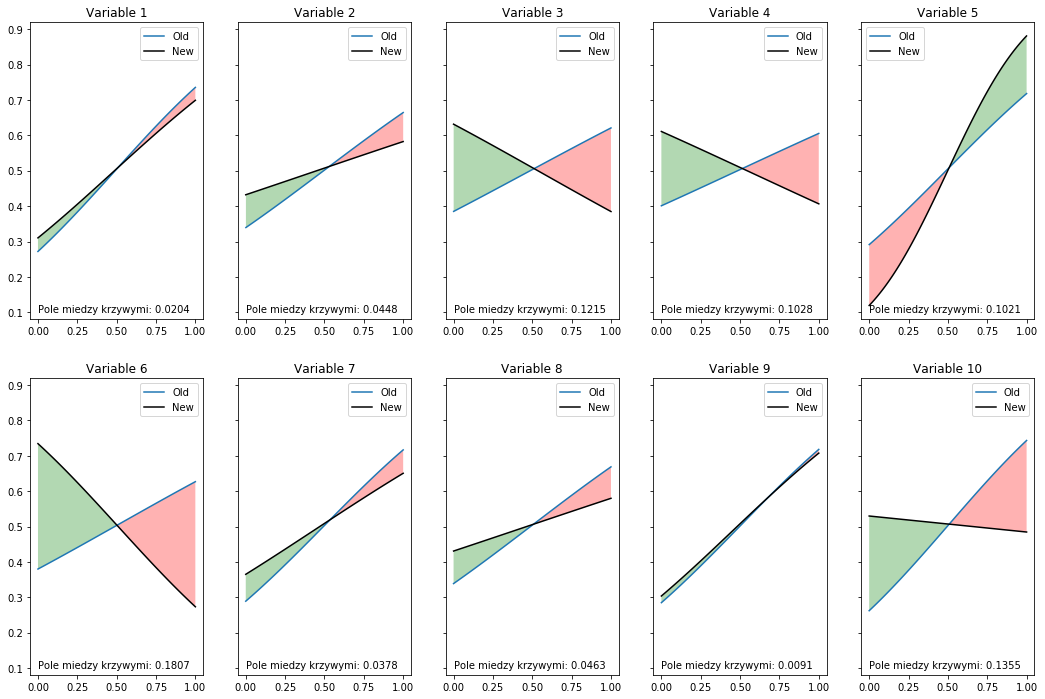

In [10]:
pdps_diff(logreg1, logreg10, X_1_test, X_10_test, 100)

Bardzo ładnie widać zmianę w odpowiedzi modelu. Największa nastąpiła dla zmiennych 3, 4, 6 i 10. Cały ten przykład ilustruje, że concept drift może przyjąć różne formy. Tutaj rozkłady brzegowe predyktorów nie zmieniają się, a za to zmienia się reguła stojąca za określeniem przynależności do klasy.